In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Data EDA & preparation

Let's start by exploring values related to customers, according with the variables descriptions the attributed related to customers are 
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

What I'd like to find insights that lead us to a comprehension of the data. That is, find customers characteristics.

I use to start my explorations on dates and amounts because, under my experience, there is always easy-to-find extream values.

In [2]:
df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv', sep="\t", parse_dates=['Dt_Customer'])
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


Looking at histograms, we have two things to take into consideration:

1. `Year_Birth` has values previous 1940. That is weird because that means customers older than 80 years and life expectancy, at least in north america, is roughly 80 years.
2. `Income` has very extream values, that is easy to see because incomes shouldn't have such long right tail (left tails would be even weird, we don't use to have negative income)

The next step would be look into these extream values, and decide wether keep or remove them. To do this analysis, my best option is do a 'close up' and see what we found there.

<AxesSubplot:ylabel='Frequency'>

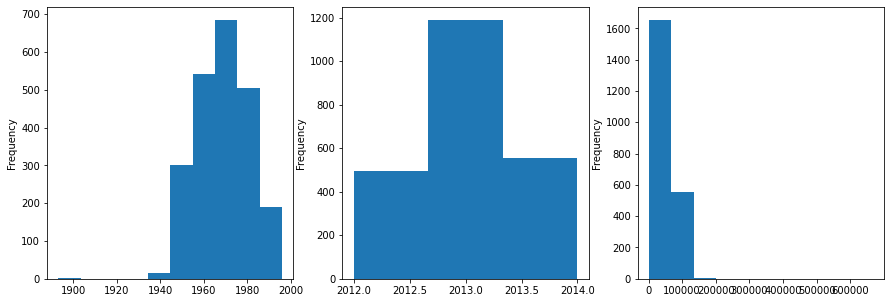

In [3]:
_,ax = plt.subplots(1,3,figsize=(15,5))

df.Year_Birth.plot.hist(ax=ax[0])
df.Dt_Customer.dt.year.plot.hist(ax=ax[1], bins=3)
df.Income.plot.hist(ax=ax[2])

## Customers greater than 80 years old

What we're doing next, is understanding those values beyond 1940. As we can see, there are 3 customers greater than 100 years when they made their last purchase.

I really don't know if someone greater than 100 years would go to a store and buy they groceries, but they are clearly outliers and don't require much processing to be removed (they just represent 4 records).

Maybe these values are errors during capturing, so I'll leave them and see in a further analysis doing a interpolation and change those values or remove them.

In [4]:
# Checking `Year_Birth` lower than 1940

df.query(
    "Year_Birth <= 1940"
).assign(
    age_when_last_purchase = lambda df: df.Dt_Customer.dt.year.sub(df.Year_Birth)
).filter(
    ['ID','Year_Birth','Dt_Customer','age_when_last_purchase','Income']
)

,ID,Year_Birth,Dt_Customer,age_when_last_purchase,Income
192,7829,1900,2013-09-26,113,36640.0
239,11004,1893,2014-05-17,121,60182.0
339,1150,1899,2013-09-26,114,83532.0
1950,6663,1940,2013-08-07,73,51141.0


## Customer with high incomes

Next, exploring incomes. Surely, we'll find extream values with low representation inside the database. We're looking for high representative populations to do a correct segmentations, and extream values are problematic to reach this goal.

The first thing to do is a close up to values beyond a threshold, the threshold can be set looking at percentiles 5, 10, 90 and 95. There we have as lower yearly income as 1,730 and as higher as 666,666 (we should see why is this value, maybe is a way to represent emptiness).

The close up I choose is from percentile 90 but lower than 666,666, results shows outliers just in `Year_Birth`.

In [5]:
# Checking incomes distributions
df.Income.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95])

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
5%        18985.500000
10%       24117.500000
25%       35303.000000
50%       51381.500000
75%       68522.000000
90%       79844.000000
95%       84130.000000
max      666666.000000
Name: Income, dtype: float64

<AxesSubplot:ylabel='Frequency'>

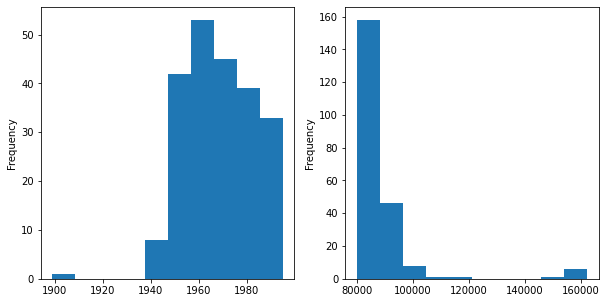

In [6]:
_,ax = plt.subplots(1,2,figsize=(10,5))
df.query("Income >= 79_844 and Income < 666_666").Year_Birth.plot.hist(ax=ax[0])
df.query("Income >= 79_844 and Income < 666_666").Income.plot.hist(ax=ax[1])

## Marital Status Exploration

In fact, married is the most popular status, it's has lower variance than together or even single.

Together, Married and Divorced has nearly the same median, Single is a bit lower than those three. Widow, Alone, Absurd and YOLO are goind to be grouped, this way we can reduce a bit the variance inside the data.

<AxesSubplot:xlabel='Income', ylabel='Marital_Status'>

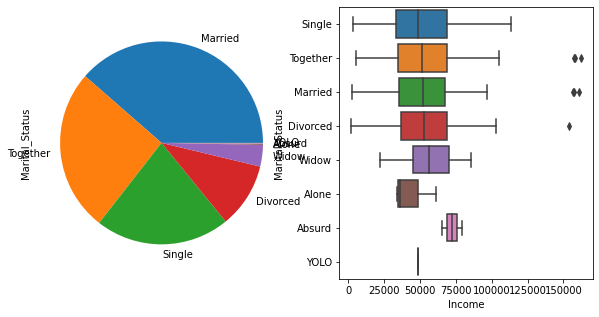

In [7]:
_,ax = plt.subplots(1,2,figsize=(10,5))
df.Marital_Status.value_counts().plot.pie(ax=ax[0])
sns.boxplot(data=df.query("Income < 666_666"), y='Marital_Status', x='Income', ax=ax[1])

In [8]:
def group_marital_status(df):
    return np.where(
        df.Marital_Status.isin(['Widow','Alone','Absurd','YOLO']),
        "Non Common",
        df.Marital_Status
    )

df = df.assign(
    Marital_Status_grouped = lambda df: group_marital_status(df)
)

<AxesSubplot:xlabel='Income', ylabel='Marital_Status_grouped'>

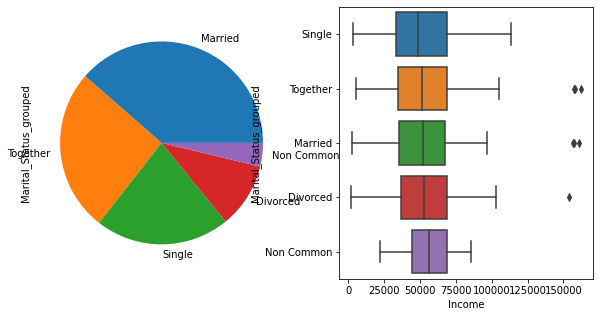

In [9]:
_,ax = plt.subplots(1,2,figsize=(10,5))
df.Marital_Status_grouped.value_counts().plot.pie(ax=ax[0])
sns.boxplot(data=df.query("Income < 666_666"), y='Marital_Status_grouped', x='Income', ax=ax[1])

## Recency Exploration

Contrary to the other variables, this seems to be more equally distributed. What we are looking here is identify break points that give us some insights to split the data.

<AxesSubplot:ylabel='Frequency'>

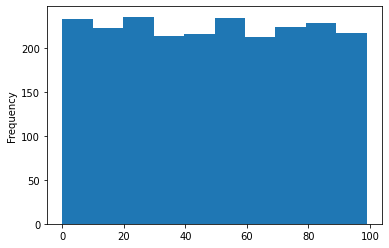

In [10]:
df.Recency.plot.hist()

# Next steps

## Interpolation

I'm not really worry about year birth outliers, because they are just 4 records. But income outliers could be a problem, from our 2,240 records they represent 10% of the data, that's an issue in such a small dataset. Hopefully we can do something about those 2 problems.

First of all, I'll remove that 666,666 income (it's a record) and the empty ones (I didn't notice earlier). Leaving the Year_Birth outliers to perform a simple interpolation.

Before anything else, let's understand customers attributes in general and particular. Then we can propose a value and confirm it using a ML model.

In [11]:
def clear_wrong_year_birth(df):
    return np.where(
        df.Year_Birth.lt(1940),
        np.nan,
        df.Year_Birth
    )

def clear_wrong_income(df):
    return np.where(
        df.Income.ge(666_666),
        np.nan,
        df.Income
    )

df = df.assign(
    Year_Birth_Interpolated = lambda df: clear_wrong_year_birth(df),
    Income_Interpolated = lambda df: clear_wrong_income(df)
)

## Infering missings

I'm plotting the missing from both `Income` and `Year_Birth`. The result shows when `Year_Birth` is empty, `Income` is not and vice versa.

Now, the second task is to identify a correlation that lead us to a model to interpolate those missing values. The perfect tool for this task is a heatmap.

In [12]:
df.query(
    "Year_Birth_Interpolated != Year_Birth_Interpolated or Income_Interpolated != Income_Interpolated"
)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Marital_Status_grouped,Year_Birth_Interpolated,Income_Interpolated
10,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,...,0,0,0,0,3,11,0,Married,1983.0,NaN
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,...,0,0,0,0,3,11,0,Single,1986.0,NaN
43,7281,1959,PhD,Single,NaN,0,0,2013-05-11,80,81,...,0,0,0,0,3,11,0,Single,1959.0,NaN
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,...,0,0,0,0,3,11,0,Single,1951.0,NaN
58,8557,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11,...,0,0,0,0,3,11,0,Single,1982.0,NaN
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,...,0,0,0,0,3,11,0,Married,1973.0,NaN
90,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230,...,0,0,0,0,3,11,0,Married,1957.0,NaN
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,...,0,0,0,0,3,11,0,Single,1957.0,NaN
92,5798,1973,Master,Together,NaN,0,0,2013-11-23,87,445,...,0,0,0,0,3,11,0,Together,1973.0,NaN
128,8268,1961,PhD,Married,NaN,0,1,2013-11-07,23,352,...,0,0,0,0,3,11,0,Married,1961.0,NaN


For `Income` there are two positive candidates, `MntMeatProducts` and `NumCatalogPurchases`. In fact the correlations can be considered strong, the scatter plot shows a non linear relationship. We can try to fit a linear regressor and analysis or look for non linear method to solve this task.

However, `Year_Birth` hasn't the same luck. But not everything is lost, we can try to plot all its relationships looking for one non linear, at least.

<AxesSubplot:>

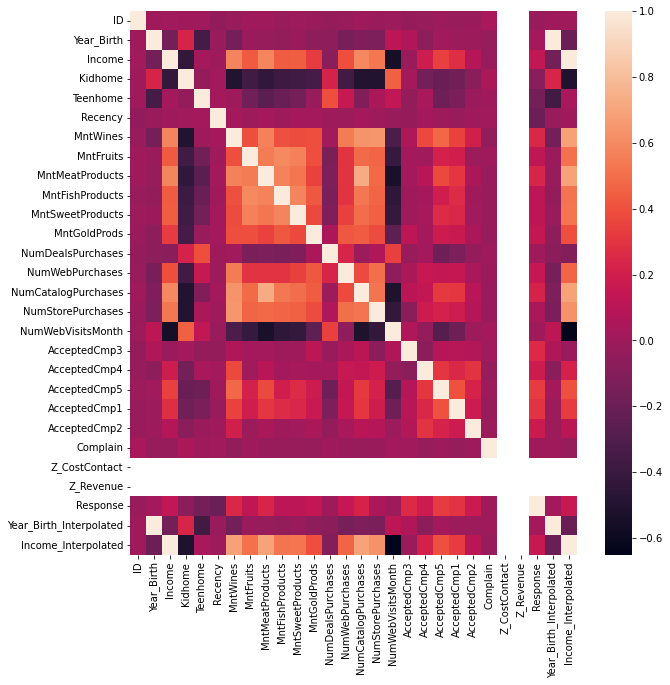

In [13]:
_,ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    df.query("Year_Birth_Interpolated == Year_Birth_Interpolated or Income_Interpolated == Income_Interpolated").corr(),
    ax=ax
)

### Interpolating `Income`

As we can see at the scatter plots, `MntMeatProducts` and `NumCatalogPurchases` seem to have a non linear relationship with `Income`. And a really detailed one for `MntMeatProducts`. Starting from here, we are going to develop a model that reproduce this behaviour to do an more precise interpolation on `Income`.

<AxesSubplot:xlabel='Income', ylabel='MntMeatProducts'>

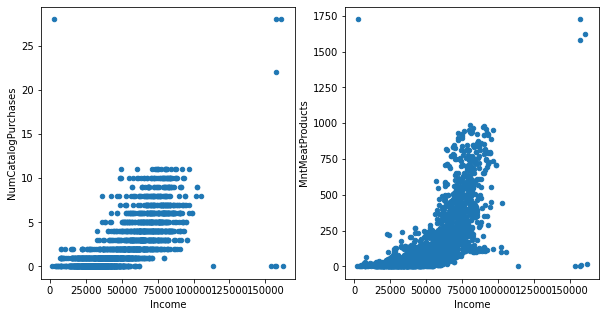

In [14]:
_,ax = plt.subplots(1,2,figsize=(10,5))
df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and Income_Interpolated == Income_Interpolated"
).plot.scatter(
    x='Income',
    y='NumCatalogPurchases',
    ax=ax[0]
)

df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and Income_Interpolated == Income_Interpolated"
).plot.scatter(
    x='Income',
    y='MntMeatProducts',
    ax=ax[1]
)

To start modeling, I'll remove outlier from both `Income` and `MntMeatProducts` to let the model focuse on the really important things. An easy technique to remove outliers is using IQR.

> Quick refresh: IQR is defined as $Q_{75}-Q_{25}$ Then removing outliers is as simple as filtering values lower than $Q_{75}+3*IQR$ and, in case you need it, values greater than $Q_{25}-3*IQR$

In [15]:
q25 = df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and Income_Interpolated == Income_Interpolated"
).MntMeatProducts.quantile(q=0.25)
q75 = df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and Income_Interpolated == Income_Interpolated"
).MntMeatProducts.quantile(q=0.75)
iqr = q75 - q25
meat_products_right_tail = q75+3*iqr

In [16]:
q25 = df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and Income_Interpolated == Income_Interpolated"
).Income.quantile(q=0.25)
q75 = df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and Income_Interpolated == Income_Interpolated"
).Income.quantile(q=0.75)
iqr = q75 - q25
income_right_tail = q75+3*iqr

<AxesSubplot:xlabel='MntMeatProducts', ylabel='Income'>

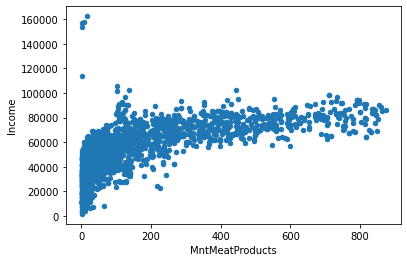

In [17]:
# The plot shows less outliers of high value for MntMeatProducts
df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and \
     Income_Interpolated == Income_Interpolated and \
     MntMeatProducts < @meat_products_right_tail and \
     Income < @income_right_tail"
).plot.scatter(
    y='Income',
    x='MntMeatProducts',
)

Once outliers are no more in the way, we can prepare an easy regression model using `statsmodels`. The way we are doing this is by creating non linear relationship apply a `log` operator over `MntMeatProducts`. How I know this? Well, take your data and try transformations that roughtly look like your desire plot. Surely their will be better ways to do that, and I'll love to read about it if you'd like to share it :)

In [18]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

data_income_interpolation = data=df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated and \
     Income_Interpolated == Income_Interpolated and \
     MntMeatProducts < @meat_products_right_tail and \
     Income < @income_right_tail"
)

income_lm = ols(
    "Income ~ np.log(MntMeatProducts+1)",
    data=data_income_interpolation
).fit()
print(income_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     3270.
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:41:29   Log-Likelihood:                -23833.
No. Observations:                2184   AIC:                         4.767e+04
Df Residuals:                    2182   BIC:                         4.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

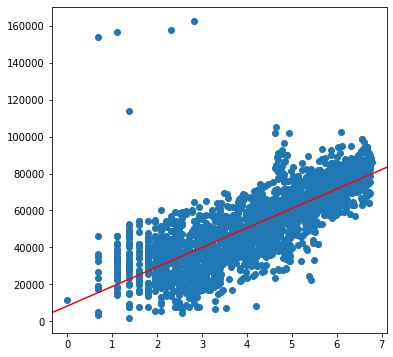

In [19]:
# Plot the fitted data against the regression line, under my perception it's not bad
from statsmodels.graphics.api import interaction_plot, abline_plot

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    np.log(
        data_income_interpolation.MntMeatProducts.values+1
    ),
    data_income_interpolation.Income.values
)

fig = abline_plot(
    intercept=income_lm.params["Intercept"],
    slope=income_lm.params["np.log(MntMeatProducts + 1)"],
    ax=ax,
    color='red'
)

In [20]:
# An important part is evaluation the model. I tried the `mean_squared_error` but it returns a very high value.
# Then I though I need to compare apples with apples, so the mean square log error shows better results.
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(
    data_income_interpolation.assign(
        Income_Pred = income_lm.predict(df.MntMeatProducts).round(2)
    ).Income,
    data_income_interpolation.assign(
        Income_Pred = income_lm.predict(df.MntMeatProducts).round(2)
    ).Income_Pred
)

0.12247357838218578

In [21]:
# Finally, we have Income interpolated with consistent data.
df = df.assign(
    Income_Pred = lambda df: income_lm.predict(df.MntMeatProducts).round(2),
    Income_Interpolated = lambda df: df.Income_Interpolated.fillna(df.Income_Pred)
).drop(
    columns="Income_Pred"
)

# Next Step

### Interpolate `Year_Birth`

This will be hard, because `Year_Birth` doesn't give any insight to somewhere to look at for a correlation.

In [22]:
df.query(
    "Year_Birth_Interpolated == Year_Birth_Interpolated or Income_Interpolated == Income_Interpolated"
).corr().loc['Year_Birth'].sort_values(ascending=False)

Year_Birth                 1.000000
Year_Birth_Interpolated    1.000000
Kidhome                    0.230176
NumWebVisitsMonth          0.121139
AcceptedCmp3               0.061774
Response                   0.021325
AcceptedCmp5               0.007123
ID                         0.000028
AcceptedCmp1              -0.005930
AcceptedCmp2              -0.006539
MntFruits                 -0.017917
MntSweetProducts          -0.018133
Recency                   -0.019871
Complain                  -0.030128
MntMeatProducts           -0.030872
MntFishProducts           -0.041625
AcceptedCmp4              -0.060510
NumDealsPurchases         -0.060846
MntGoldProds              -0.061818
NumCatalogPurchases       -0.121275
NumStorePurchases         -0.128272
NumWebPurchases           -0.145040
MntWines                  -0.157773
Income                    -0.161791
Income_Interpolated       -0.196940
Teenhome                  -0.352111
Z_CostContact                   NaN
Z_Revenue                   